In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.ndimage import median_filter
import nibabel
import MedianFilter

In [16]:
GPUBackend='OpenCL'
if GPUBackend=='OpenCL':
    MedianFilter.InitOpenCL('M1')
else:
    MedianFilter.InitMetal('M1')

Apple M1 Max
Selecting device:  Apple M1 Max


In [17]:
a=nibabel.load('/Volumes/GoogleDrive/My Drive/Calgary/LIFU System Preparations/LIFU1 Data and Sofware/Participants/LIFU1-01/m2m_SimbNIBS_LIFU_01/M1_250kHz_6PPW_BabelViscoInput.nii.gz')
# a=nibabel.load('/Volumes/GoogleDrive/My Drive/Calgary/LIFU System Preparations/LIFU1 Data and Sofware/Participants/LIFU1-01/M1_700kHz_9PPW_BabelViscoInput.nii.gz')
data=a.get_fdata().astype(np.uint8)
data+=np.random.randint(0,4,size=data.shape,dtype=data.dtype)
data=np.ascontiguousarray(data)

In [18]:
data_filter=MedianFilter.MedianFilterSize7(data,GPUBackend=GPUBackend)

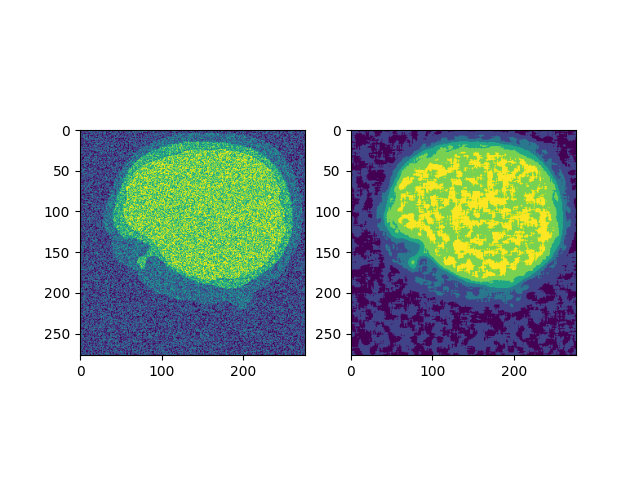

In [8]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(data[:,:,200])
plt.subplot(1,2,2)
plt.imshow(data_filter[:,:,200])

In [19]:
%%timeit
MedianFilter.MedianFilterSize7(data,GPUBackend=GPUBackend)

2.01 s ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
MedianFilter.InitMetal('M1')


Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)


In [21]:
data_filter_metal=MedianFilter.MedianFilterSize7(data,GPUBackend='Metal')

In [22]:
np.all(data_filter_metal==data_filter)

True

In [23]:
%%timeit
MedianFilter.MedianFilterSize7(data,GPUBackend='Metal')

1.4 s ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
